In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 8]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
from datetime import datetime
df.Month = df.Month.apply(lambda x: datetime.strptime(x, '%Y-%m'))
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [7]:
df.set_index('Month', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


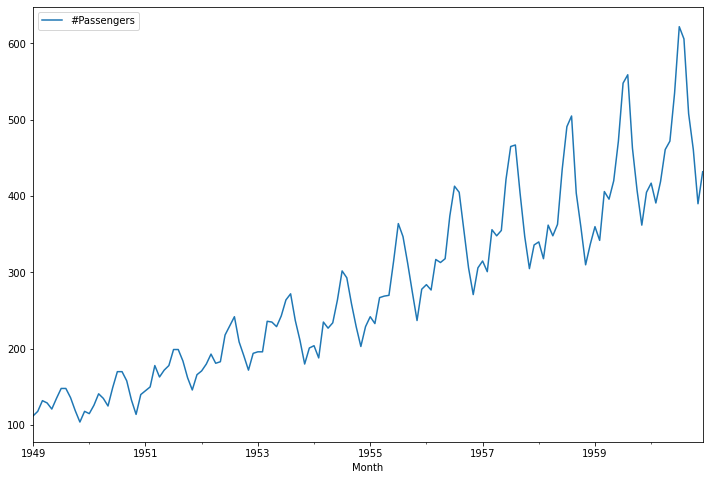

In [8]:
df.plot()
plt.show()

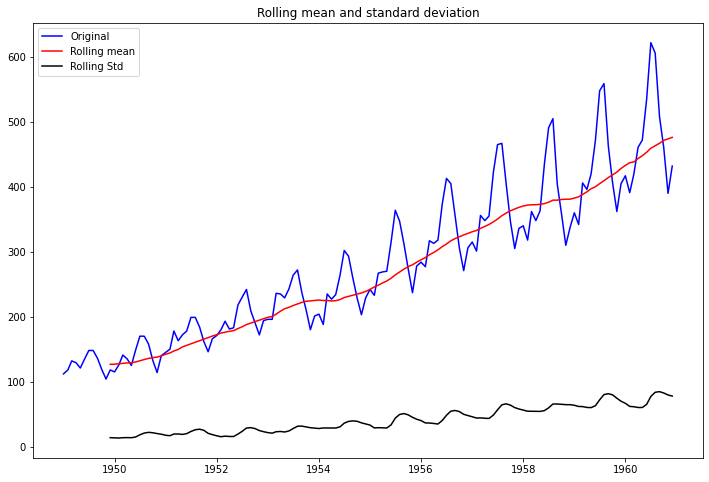

Result of Dickey:Fuller test:
Test Statistics                  0.815369
p-Value                          0.991880
#Lags used                      13.000000
Number of observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [9]:
def stationary_test(data):
  rolling_mean = data.rolling(window=12).mean()
  rolling_std = data.rolling(window=12).std()

  # plots
  original_plot = plt.plot(data, label='Original', color='blue')
  mean = plt.plot(rolling_mean, label='Rolling mean', color='red')
  std = plt.plot(rolling_std, label='Rolling Std', color='black')
  plt.legend(loc='best')
  plt.title("Rolling mean and standard deviation")
  plt.show(block=False)

  test = ts.adfuller(data['#Passengers'])
  result = pd.Series(test[0:4], index=['Test Statistics', 'p-Value', '#Lags used', 'Number of observations used'])
  for key, value in test[4].items():
    result['Critical value (%s)'%key] = value
  print('Result of Dickey:Fuller test:')
  print(result)
stationary_test(df)

As we see P value is 0.99 therefore we fail to reject null hypothesis hence its a non-stationary time series

In [10]:
# moving average model
df['roll-12'] = df.rolling(window=2).mean()

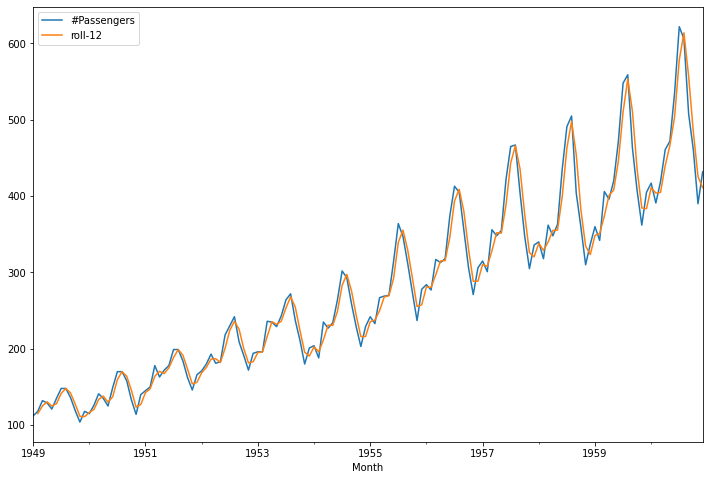

In [11]:
# plotting moving averages
df.plot()

**Check whether time series is stationary or not**

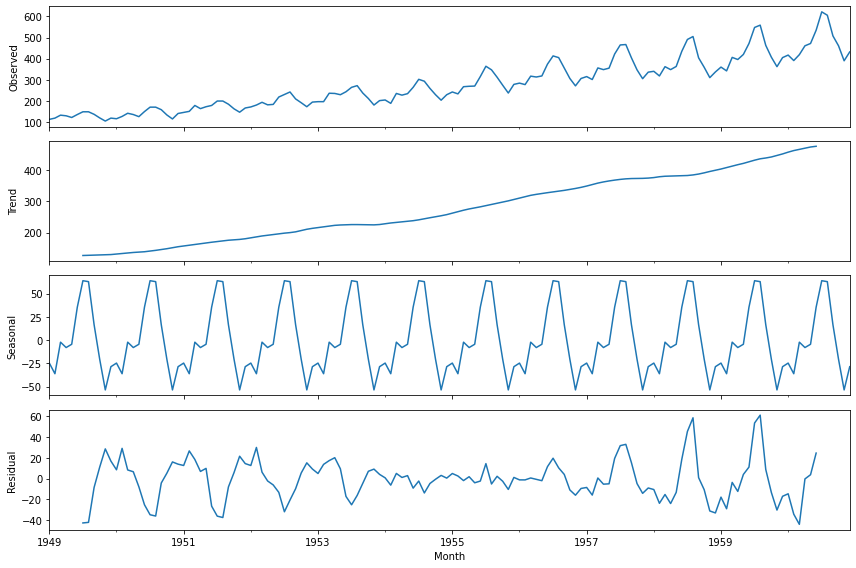

In [12]:
decomposition = sm.tsa.seasonal_decompose(df['#Passengers'], model="additive")
fig = decomposition.plot()

**Lets make time series stationary**


1.   First thing you can do is differencing. When to apply differencing? Ans: When you have a very high increasing or decreasing trend.
2.   



In [13]:
# case 1: Differencing
df.drop(columns=['roll-12'], inplace=True)
df_1 = df.diff()
df_1.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


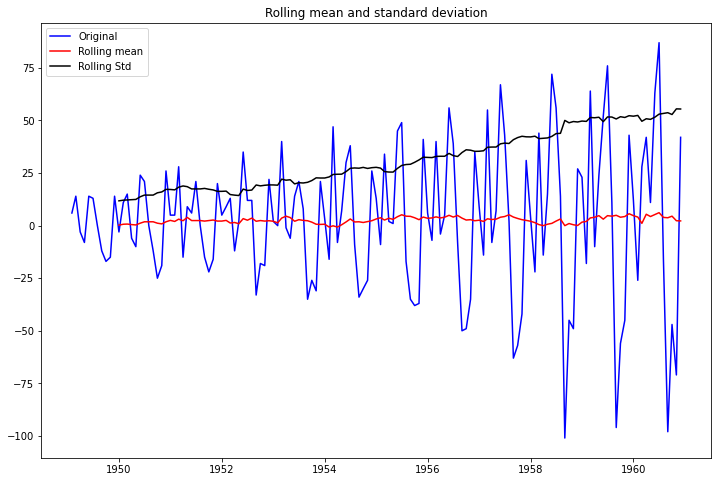

Result of Dickey:Fuller test:
Test Statistics                 -2.829267
p-Value                          0.054213
#Lags used                      12.000000
Number of observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [14]:
df_1.dropna(inplace=True)
stationary_test(df_1)

pvalue greater than 5%. hence not stationary

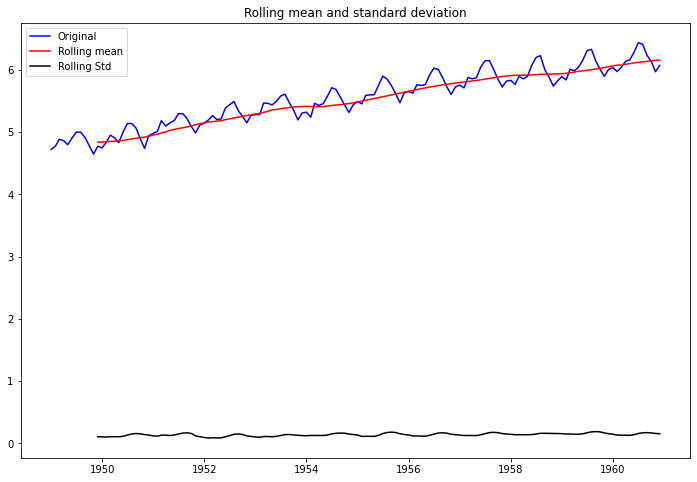

Result of Dickey:Fuller test:
Test Statistics                 -1.717017
p-Value                          0.422367
#Lags used                      13.000000
Number of observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [15]:
#case 2: lets apply a log transformation.
df_log = np.log(df)

stationary_test(df_log)

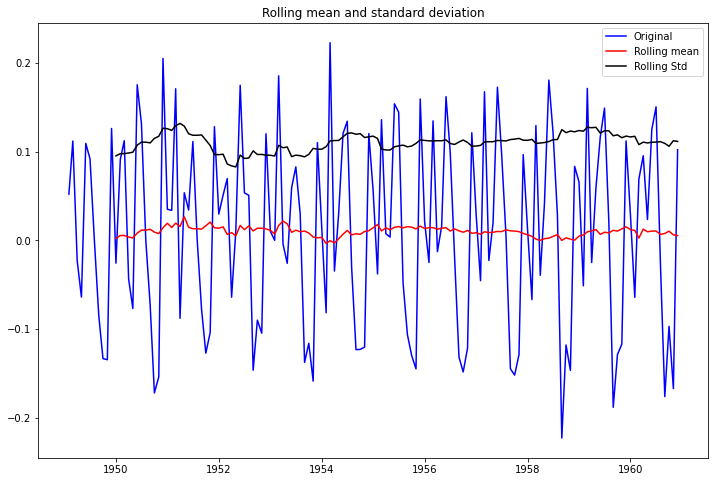

Result of Dickey:Fuller test:
Test Statistics                 -2.717131
p-Value                          0.071121
#Lags used                      14.000000
Number of observations used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


In [16]:
#case 3: lets apply diff.
df_log_diff = df_log.diff()

stationary_test(df_log_diff.dropna())

**This shows, if you have a highly increasing trend then always do diffeencing**
Enen diff after log is not working as p value is higher than the differencing done single time.

**Note**: When we apply differencing we only deal with problem in stationarity due to trend. In order to deal with problem with seasonality we have to bring in moving average concept.

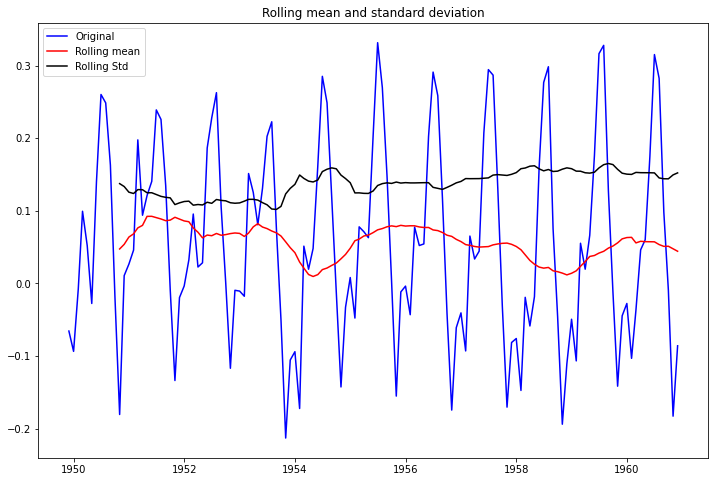

Result of Dickey:Fuller test:
Test Statistics                 -3.162908
p-Value                          0.022235
#Lags used                      13.000000
Number of observations used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


In [17]:
#case 4: Moving average concept
# calculate moving average of log_transformed of data
moving_avg = df_log.rolling(window=12).mean()
# lets subtract moving average from log transformed series

df_log_ma = df_log - moving_avg
df_log_ma.dropna(inplace=True)
stationary_test(df_log_ma)

Data looks stationary now.
Lets look at **ARIMA** model and how data is represented in it
# y_pred = a + b*Yt-1 + c*Yt-2 +.......
How far we go is a hyperparamerter that we have to determine in Auto regression of ARIMA.

1.   AR: AutoRegression. A model that uses the dependant relationship between an observed and some number of lagged observations.
2.   I: Integrated. The use of differencing of raw observations, in order to make the time series stationary.
3. MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observation.

hyperparamerters are in same order as:
1. p: number of lagged observations included in the model. Also known as lag order.
2. d: The number of times the raw observations are differenced. Also called degree of differencing.
3. The size of moving average window. Also called order of moving average.

Text(0.5, 1.0, 'Partial Auto correlation function')

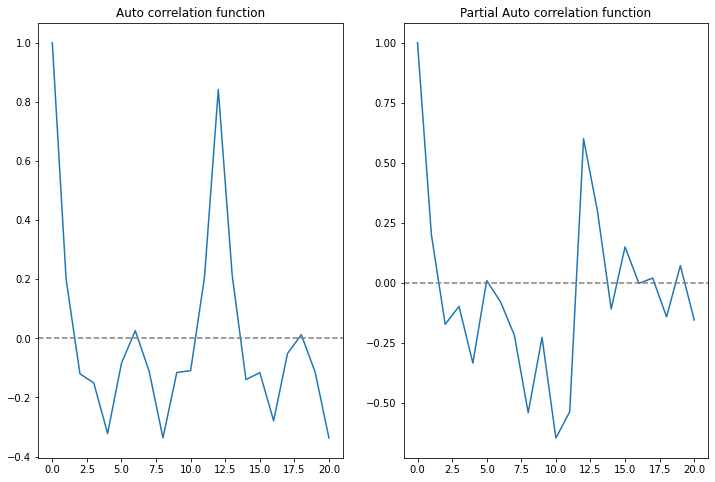

In [18]:
# Lets find p, q using acf, and pacf curve
# acf = auto corelation fuction. We try to find out how the current is correlated with the past values.
# pacf = partial acf. 

lag_acf = ts.acf(df_log_diff.dropna(), nlags=20)
lag_pacf = ts.pacf(df_log_diff.dropna(), nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.title('Auto correlation function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.title('Partial Auto correlation function')

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Wed, 23 Dec 2020   AIC                           -287.281
Time:                        17:42:26   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passeng

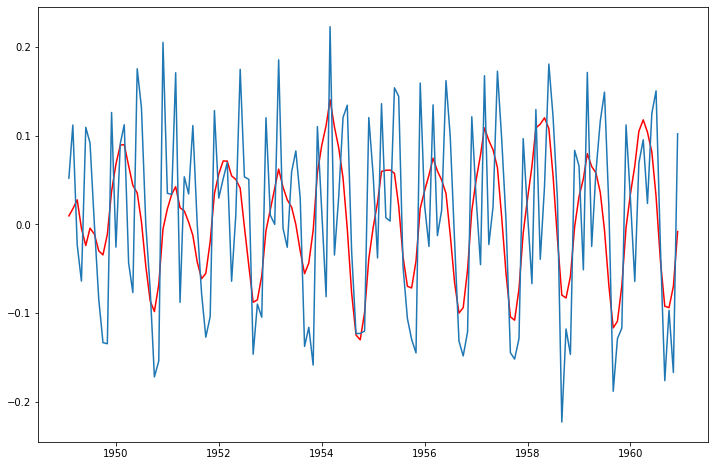

In [19]:
# we find the value of x when curve cuts x-axis for the first time to be from rage 1-2. Lets use these as a p,q
model = ARIMA(df_log, order=(2,1,2))
result_ARIMA = model.fit(disp=-1)

plt.plot(result_ARIMA.fittedvalues, color='red')
plt.plot(df_log_diff.dropna())
print(result_ARIMA.summary())

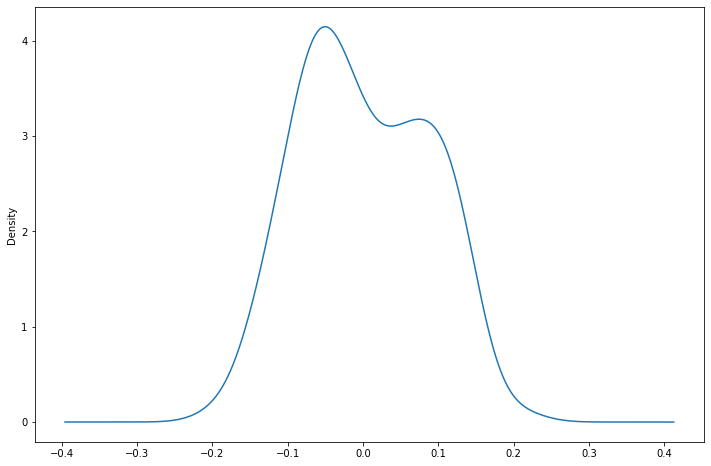

In [20]:
residual = result_ARIMA.resid
residual.plot(kind='kde')

In [21]:
residual.describe()

count    143.000000
mean       0.001691
std        0.085116
min       -0.193387
25%       -0.063327
50%       -0.005020
75%        0.074605
max        0.210671
dtype: float64

In [22]:
pred = pd.Series(result_ARIMA.fittedvalues)
pred.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [23]:
# simce differecing and log were applied to data so we reverse the transformation
pred = pred.cumsum()
pred.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [38]:
final_pred = pd.Series(data=df_log.iloc[0]['#Passengers'], index=df_log.index)
final_pred = final_pred.add(pred, fill_value=0)
final_pred.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

In [39]:
final_pred = np.exp(final_pred)
final_pred.head()

Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073415
1949-04-01    118.301990
1949-05-01    117.768366
dtype: float64

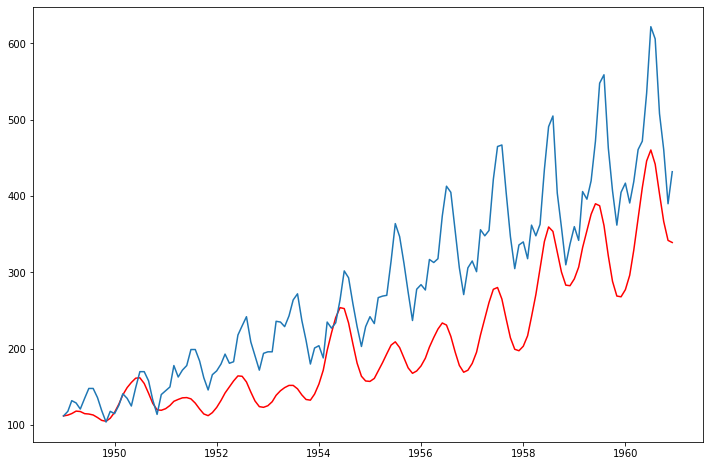

In [40]:
plt.plot(final_pred, color='red')
plt.plot(df)
plt.show()